# Analyse Exploratoire

A réaliser : 
- Une analyse descriptive des données, y compris une explication du sens des colonnes gardées, des arguments derrière la suppression de lignes ou de colonnes, des statistiques descriptives et des visualisations pertinentes.

## Import des modules

In [422]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

In [423]:
bc_csv = pd.read_csv("data/2016_Building_Energy_Benchmarking.csv")
print(f"Dataset initial : {len(bc_csv)} bâtiments, {bc_csv.shape[1]} colonnes")

Dataset initial : 3376 bâtiments, 46 colonnes


In [424]:
# On regarde comment un batiment est défini dans ce jeu de données 
bc_csv.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,...,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,...,8.115253e+05,2768924.0,18112.13086,1811213.0,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,...,1.573449e+06,5368607.0,88039.98438,8803998.0,False,NaN,Compliant,NaN,505.01,2.88


Variables identifiées par catégories :  
- Identification :  
    OSEBuildingID, PropertyName, Address, City, State, ZipCode, TaxParcelIdentificationNumber
- Géolocalisation :   
    Latitude, Longitude, Neighborhood, CouncilDistrictCode  
- Caractéristiques physiques :   
    YearBuilt, NumberofFloors, NumberofBuildings,PropertyGFATotal, PropertyGFABuilding(s),PropertyGFAParking, LargestPropertyUseTypeGFA, SecondLargestPropertyUseTypeGFA, ThirdLargestPropertyUseTypeGFA
- Usage :   
    BuildingType, PrimaryPropertyType, ListOfAllPropertyUseTypes, LargestPropertyUseType, SecondLargestPropertyUseType, ThirdLargestPropertyUseType, ComplianceStatus, Outlier
- Performance énergétique :   
    YearsENERGYSTARCertified, ENERGYSTARScore, SiteEUI(kBtu/sf), SiteEUIWN(kBtu/sf), SourceEUI(kBtu/sf), SourceEUIWN(kBtu/sf)
- Consommation :   
    DataYear, SiteEnergyUse(kBtu), SiteEnergyUseWN(kBtu), Electricity(kWh) , Electricity(kBtu), NaturalGas(therms), NaturalGas(kBtu), SteamUse(kBtu)  
- Émissions :   
    TotalGHGEmissions, GHGEmissionsIntensity 
- Autres

## Suppression de champs inutiles

In [425]:
bc_csv.drop(columns=['OSEBuildingID', 'PropertyName', 'Address', 'City', 'State', 'ZipCode', 'TaxParcelIdentificationNumber'], inplace=True)

## Traitements des outliers déclarés

In [426]:
mask = bc_csv['Outlier'].notna()
bc_csv[mask]

,DataYear,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
226,2016,NonResidential,Large Office,7,DOWNTOWN,47.60642,-122.33581,1958,1.0,6,...,1.166315e+07,39794668.0,16048.309570,1604831.0,False,NaN,Non-Compliant,High outlier,362.66,2.10
384,2016,NonResidential,Retail Store,4,NORTHEAST,47.66178,-122.31812,1987,1.0,2,...,9.348260e+04,318963.0,0.000000,0.0,False,NaN,Non-Compliant,Low outlier,2.22,0.03
448,2016,NonResidential,Large Office,2,DOWNTOWN,47.59878,-122.33458,1913,5.0,7,...,4.715030e+05,1608768.0,3430.500488,343050.0,False,NaN,Non-Compliant,Low outlier,29.43,0.19
517,2016,NonResidential,Large Office,7,MAGNOLIA / QUEEN ANNE,47.62235,-122.36378,2000,1.0,4,...,7.953454e+06,27137187.0,0.000000,0.0,False,NaN,Non-Compliant,High outlier,189.18,1.46
720,2016,Multifamily HR (10+),High-Rise Multifamily,7,DOWNTOWN,47.61706,-122.35141,1982,1.0,24,...,6.265616e+05,2137828.0,2700.760010,270076.0,False,NaN,Non-Compliant,Low outlier,29.25,0.17
834,2016,Multifamily LR (1-4),Low-Rise Multifamily,3,EAST,47.62059,-122.32440,1989,1.0,4,...,7.502090e+04,255971.0,0.000000,0.0,False,NaN,Non-Compliant,Low outlier,1.78,0.06
839,2016,SPS-District K-12,K-12 School,7,MAGNOLIA / QUEEN ANNE,47.63203,-122.35337,2001,1.0,1,...,7.228240e+04,246628.0,1848.439575,184844.0,True,NaN,Error - Correct Default Data,Low outlier,11.54,0.32
962,2016,Multifamily LR (1-4),Low-Rise Multifamily,1,SOUTHWEST,47.58143,-122.37510,1990,1.0,3,...,2.058855e+05,702481.0,0.000000,0.0,False,NaN,Non-Compliant,Low outlier,4.90,0.07
1045,2016,NonResidential,Retail Store,2,GREATER DUWAMISH,47.56535,-122.34054,1953,1.0,1,...,1.436250e+04,49005.0,964.640015,96464.0,True,NaN,Error - Correct Default Data,Low outlier,5.46,0.14
1229,2016,NonResidential,Small- and Mid-Sized Office,7,DOWNTOWN,47.61119,-122.33581,1903,1.0,3,...,7.064900e+03,24105.0,0.000000,0.0,False,NaN,Non-Compliant,Low outlier,0.17,0.00


In [427]:
# Tous sont non-compliant concernant la conformité aux normes de relevés énergétiques - Nous les éliminons
bc_without_outliers = bc_csv[~mask].copy()
print(f"Après filtrage des outliers déclarés : {len(bc_csv)} → {len(bc_without_outliers)} bâtiments")

Après filtrage des outliers déclarés : 3376 → 3344 bâtiments


## Traitement des usages
### Affichage des usages utilisés

In [428]:
use_types = []
for i,row in bc_without_outliers.iterrows():
    if not pd.isna(row['ListOfAllPropertyUseTypes']):
        for use in row['ListOfAllPropertyUseTypes'].split(','):
            use =  use.strip()
            if use not in use_types:
                use_types.append(use)
                print(use)
print(f"{len(use_types)} éléments") 

Hotel
Parking
Restaurant
Swimming Pool
Police Station
Other - Entertainment/Public Assembly
Multifamily Housing
Data Center
Library
Fitness Center/Health Club/Gym
Office
Other
Other - Lodging/Residential
Social/Meeting Hall
Courthouse
K-12 School
College/University
Automobile Dealership
Retail Store
Self-Storage Facility
Energy/Power Station
Laboratory
Manufacturing/Industrial Plant
Non-Refrigerated Warehouse
Refrigerated Warehouse
Other - Education
Vocational School
Other - Mall
Personal Services (Health/Beauty
Dry Cleaning
etc)
Senior Care Community
Medical Office
Distribution Center
Hospital (General Medical & Surgical)
Museum
Repair Services (Vehicle
Shoe
Locksmith
Food Service
Residence Hall/Dormitory
Other - Services
Other/Specialty Hospital
Financial Office
Other - Utility
Fast Food Restaurant
Movie Theater
Supermarket/Grocery Store
Worship Facility
Lifestyle Center
Other - Recreation
Convenience Store without Gas Station
Pre-school/Daycare
Food Sales
Other - Restaurant/Bar
Sing

### Vérification de l'usage principal d'habitation

In [429]:
# Let's check property without largest use type
mask = bc_without_outliers['LargestPropertyUseType'].isna()
bc_without_outliers[mask][['ListOfAllPropertyUseTypes','BuildingType','PrimaryPropertyType','LargestPropertyUseType']]

,ListOfAllPropertyUseTypes,BuildingType,PrimaryPropertyType,LargestPropertyUseType
353,"Fitness Center/Health Club/Gym, Office, Other ...",NonResidential,Self-Storage Facility,NaN
578,NaN,NonResidential,Small- and Mid-Sized Office,NaN
758,NaN,Multifamily LR (1-4),Low-Rise Multifamily,NaN
1077,Multifamily Housing,Multifamily HR (10+),High-Rise Multifamily,NaN
1147,Hotel,NonResidential,Hotel,NaN
1483,Multifamily Housing,Multifamily MR (5-9),Mid-Rise Multifamily,NaN
1756,Multifamily Housing,Multifamily HR (10+),High-Rise Multifamily,NaN
1768,NaN,Multifamily LR (1-4),Low-Rise Multifamily,NaN
1792,NaN,Multifamily LR (1-4),Low-Rise Multifamily,NaN
2321,NaN,Multifamily LR (1-4),Low-Rise Multifamily,NaN


### Correction manuelle des valeurs manquantes

In [430]:
mask = bc_without_outliers['LargestPropertyUseType'].isna() & bc_without_outliers['PrimaryPropertyType'].str.contains('Multifamily')
bc_without_outliers.loc[mask,'LargestPropertyUseType']= "Multifamily Housing"
mask = bc_without_outliers['LargestPropertyUseType'].isna() 
bc_without_outliers[mask][['ListOfAllPropertyUseTypes','BuildingType','PrimaryPropertyType','LargestPropertyUseType']]
bc_without_outliers.loc[mask,'LargestPropertyUseType']= bc_without_outliers.loc[mask,'PrimaryPropertyType']
mask = bc_without_outliers['ListOfAllPropertyUseTypes'].isna() 
bc_without_outliers.loc[mask,'ListOfAllPropertyUseTypes']= bc_without_outliers.loc[mask,'LargestPropertyUseType']



### Exclusion des propriétés à usage principal d'habitation (non temporaire)

In [431]:
exclude_first_use = ["Multifamily Housing", "Single Family Home","Residence Hall/Dormitory","Other - Lodging/Residential"]
mask = bc_without_outliers["LargestPropertyUseType"].isin( exclude_first_use)
bc_only_non_residential = bc_without_outliers[~mask].copy()
print(f"Après filtrage des types de propriétés : {len(bc_without_outliers)} → {len(bc_only_non_residential)} bâtiments")


Après filtrage des types de propriétés : 3344 → 1649 bâtiments


In [432]:
bc_only_non_residential['PrimaryPropertyType'].value_counts()

PrimaryPropertyType
Small- and Mid-Sized Office    290
Other                          247
Warehouse                      187
Large Office                   170
K-12 School                    137
Mixed Use Property             107
Retail Store                    89
Hotel                           76
Worship Facility                69
Distribution Center             53
Senior Care Community           45
Supermarket / Grocery Store     40
Medical Office                  39
Self-Storage Facility           28
University                      25
Refrigerated Warehouse          12
Restaurant                      12
Hospital                        10
Laboratory                      10
Office                           3
Name: count, dtype: int64

In [433]:
bc_only_non_residential['LargestPropertyUseType'].value_counts()

LargestPropertyUseType
Office                                                  492
Non-Refrigerated Warehouse                              199
K-12 School                                             137
Other                                                    99
Retail Store                                             97
Hotel                                                    77
Worship Facility                                         69
Distribution Center                                      54
Senior Care Community                                    46
Medical Office                                           41
Supermarket/Grocery Store                                41
Parking                                                  32
Other - Recreation                                       31
Self-Storage Facility                                    29
College/University                                       25
Other - Entertainment/Public Assembly                    21
Restaurant       

In [434]:
bc_only_non_residential['SecondLargestPropertyUseType'].value_counts()

SecondLargestPropertyUseType
Parking                                                 341
Office                                                  162
Retail Store                                             84
Other                                                    44
Restaurant                                               30
Non-Refrigerated Warehouse                               29
Multifamily Housing                                      17
Fitness Center/Health Club/Gym                           16
Data Center                                              12
Other - Services                                         11
Medical Office                                            8
Laboratory                                                8
Distribution Center                                       7
Bank Branch                                               7
Supermarket/Grocery Store                                 7
Other - Entertainment/Public Assembly                     6
K-12 School

In [435]:
bc_only_non_residential['ThirdLargestPropertyUseType'].value_counts()

ThirdLargestPropertyUseType
Office                                                  51
Retail Store                                            47
Parking                                                 43
Other                                                   38
Restaurant                                              31
Non-Refrigerated Warehouse                              15
Data Center                                             13
Multifamily Housing                                     12
Swimming Pool                                           10
Medical Office                                           9
Pre-school/Daycare                                       8
Food Service                                             7
Social/Meeting Hall                                      6
Bank Branch                                              5
Other - Restaurant/Bar                                   5
Other - Entertainment/Public Assembly                    4
Fitness Center/Health Club/G

In [436]:
bc_only_non_residential[['BuildingType', 'PrimaryPropertyType', 'ListOfAllPropertyUseTypes', 'LargestPropertyUseType', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 1649 entries, 0 to 3375
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   BuildingType                  1649 non-null   object
 1   PrimaryPropertyType           1649 non-null   object
 2   ListOfAllPropertyUseTypes     1649 non-null   object
 3   LargestPropertyUseType        1649 non-null   object
 4   SecondLargestPropertyUseType  852 non-null    object
 5   ThirdLargestPropertyUseType   344 non-null    object
dtypes: object(6)
memory usage: 90.2+ KB


In [437]:
mask = (bc_only_non_residential['PrimaryPropertyType'].str.contains('Other')) &  (~ bc_only_non_residential['LargestPropertyUseType'].str.contains('Other'))
bc_only_non_residential['FirstUseType'] = bc_only_non_residential['PrimaryPropertyType']
bc_only_non_residential.loc[mask,'FirstUseType'] = bc_only_non_residential.loc[mask,'LargestPropertyUseType']

In [438]:
mask = bc_only_non_residential['FirstUseType'].isna()
bc_only_non_residential['FirstUseType'].value_counts()

FirstUseType
Small- and Mid-Sized Office                             290
Warehouse                                               187
Large Office                                            170
Other                                                   156
K-12 School                                             137
Mixed Use Property                                      107
Retail Store                                             89
Hotel                                                    76
Worship Facility                                         69
Distribution Center                                      53
Senior Care Community                                    45
Supermarket / Grocery Store                              40
Medical Office                                           39
Self-Storage Facility                                    28
University                                               25
Parking                                                  17
Restaurant                 

In [439]:
mask =  (bc_only_non_residential['SecondLargestPropertyUseType'].notna())
bc_only_non_residential['SecondLargestPropertyUseType'].value_counts()

SecondLargestPropertyUseType
Parking                                                 341
Office                                                  162
Retail Store                                             84
Other                                                    44
Restaurant                                               30
Non-Refrigerated Warehouse                               29
Multifamily Housing                                      17
Fitness Center/Health Club/Gym                           16
Data Center                                              12
Other - Services                                         11
Medical Office                                            8
Laboratory                                                8
Distribution Center                                       7
Bank Branch                                               7
Supermarket/Grocery Store                                 7
Other - Entertainment/Public Assembly                     6
K-12 School

## Traitement des valeurs candidates de consommations

In [440]:
# examen des valeurs de consommations
target_cols = ['Electricity(kBtu)',  'NaturalGas(kBtu)', 'SteamUse(kBtu)','SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)']
bc_only_non_residential[target_cols] = bc_only_non_residential[target_cols].replace(0,np.nan)
bc_with_candidates = bc_only_non_residential.dropna(subset=target_cols, how='all').copy()
print(f"Après filtrage targets vides: {len(bc_only_non_residential)} → {len(bc_with_candidates)} bâtiments")
conso_details= ['Electricity(kBtu)',  'NaturalGas(kBtu)', 'SteamUse(kBtu)']
bc_with_candidates[conso_details] = bc_with_candidates[conso_details].fillna(0)
bc_with_candidates['CalcUse(kBtu)']= bc_with_candidates[conso_details].sum(axis=1)
target_cols.append('CalcUse(kBtu)')
bc_with_candidates[target_cols].info()

Après filtrage targets vides: 1649 → 1641 bâtiments
<class 'pandas.core.frame.DataFrame'>
Index: 1641 entries, 0 to 3375
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Electricity(kBtu)      1641 non-null   float64
 1   NaturalGas(kBtu)       1641 non-null   float64
 2   SteamUse(kBtu)         1641 non-null   float64
 3   SiteEnergyUse(kBtu)    1630 non-null   float64
 4   SiteEnergyUseWN(kBtu)  1620 non-null   float64
 5   CalcUse(kBtu)          1641 non-null   float64
dtypes: float64(6)
memory usage: 89.7 KB


In [441]:
mask = ((bc_with_candidates['SiteEnergyUse(kBtu)'] == 0) | (bc_with_candidates['SiteEnergyUse(kBtu)'].isna())) & (bc_with_candidates['SiteEnergyUse(kBtu)']!=0)
bc_with_candidates.loc[mask, 'SiteEnergyUse(kBtu)'] = bc_with_candidates.loc[mask,'CalcUse(kBtu)']

In [442]:
bc_with_candidates[target_cols].info()

<class 'pandas.core.frame.DataFrame'>
Index: 1641 entries, 0 to 3375
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Electricity(kBtu)      1641 non-null   float64
 1   NaturalGas(kBtu)       1641 non-null   float64
 2   SteamUse(kBtu)         1641 non-null   float64
 3   SiteEnergyUse(kBtu)    1641 non-null   float64
 4   SiteEnergyUseWN(kBtu)  1620 non-null   float64
 5   CalcUse(kBtu)          1641 non-null   float64
dtypes: float64(6)
memory usage: 89.7 KB


In [443]:
bc_with_target = bc_with_candidates.drop(columns=['CalcUse(kBtu)', 'SiteEnergyUseWN(kBtu)']).copy()

Valeur Candidate retenue : SiteEnergyUse(kBtu)


## Traitement des caractéristiques physiques
### Traitement des surfaces

In [444]:
phy_cols = ['PropertyGFATotal', 'PropertyGFABuilding(s)','PropertyGFAParking', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA']
bc_with_target[phy_cols].info()

<class 'pandas.core.frame.DataFrame'>
Index: 1641 entries, 0 to 3375
Data columns (total 6 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   PropertyGFATotal                 1641 non-null   int64  
 1   PropertyGFABuilding(s)           1641 non-null   int64  
 2   PropertyGFAParking               1641 non-null   int64  
 3   LargestPropertyUseTypeGFA        1637 non-null   float64
 4   SecondLargestPropertyUseTypeGFA  850 non-null    float64
 5   ThirdLargestPropertyUseTypeGFA   344 non-null    float64
dtypes: float64(3), int64(3)
memory usage: 89.7 KB


In [445]:
# 'YearBuilt', 'NumberofFloors', 'NumberofBuildings'
bc_with_target[phy_cols].fillna(0)
bc_with_target['3LargestGFA']= bc_with_target[['LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA']].sum(axis=1)
mask = bc_with_target['3LargestGFA']==0
bc_with_target.loc[mask, '3LargestGFA']= bc_with_target.loc[mask, 'PropertyGFATotal']
corr_values = ['SiteEnergyUse(kBtu)','SiteEnergyUse(kBtu)', 'PropertyGFATotal', 'PropertyGFABuilding(s)','PropertyGFAParking', 'LargestPropertyUseTypeGFA','3LargestGFA']
bc_with_target[corr_values].corr()

,SiteEnergyUse(kBtu),SiteEnergyUse(kBtu),PropertyGFATotal,PropertyGFABuilding(s),PropertyGFAParking,LargestPropertyUseTypeGFA,3LargestGFA
SiteEnergyUse(kBtu),1.000000,1.000000,0.809844,0.826476,0.144106,0.845250,0.857504
SiteEnergyUse(kBtu),1.000000,1.000000,0.809844,0.826476,0.144106,0.845250,0.857504
PropertyGFATotal,0.809844,0.809844,1.000000,0.990217,0.379024,0.978485,0.982624
PropertyGFABuilding(s),0.826476,0.826476,0.990217,1.000000,0.246190,0.983148,0.977360
PropertyGFAParking,0.144106,0.144106,0.379024,0.246190,1.000000,0.276385,0.343594
LargestPropertyUseTypeGFA,0.845250,0.845250,0.978485,0.983148,0.276385,1.000000,0.981608
3LargestGFA,0.857504,0.857504,0.982624,0.977360,0.343594,0.981608,1.000000


In [446]:
bc_with_target['3LargestGFA'].describe()

count    1.641000e+03
mean     1.219627e+05
std      3.059045e+05
min      8.223000e+03
25%      3.017200e+04
50%      5.075900e+04
75%      1.055630e+05
max      9.320156e+06
Name: 3LargestGFA, dtype: float64

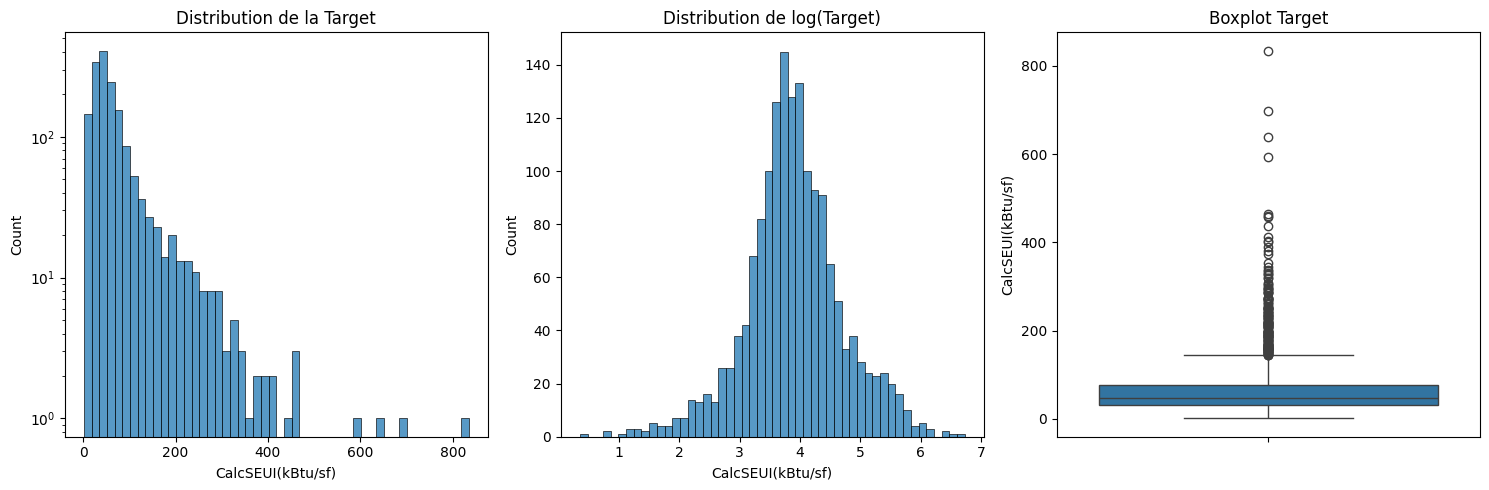

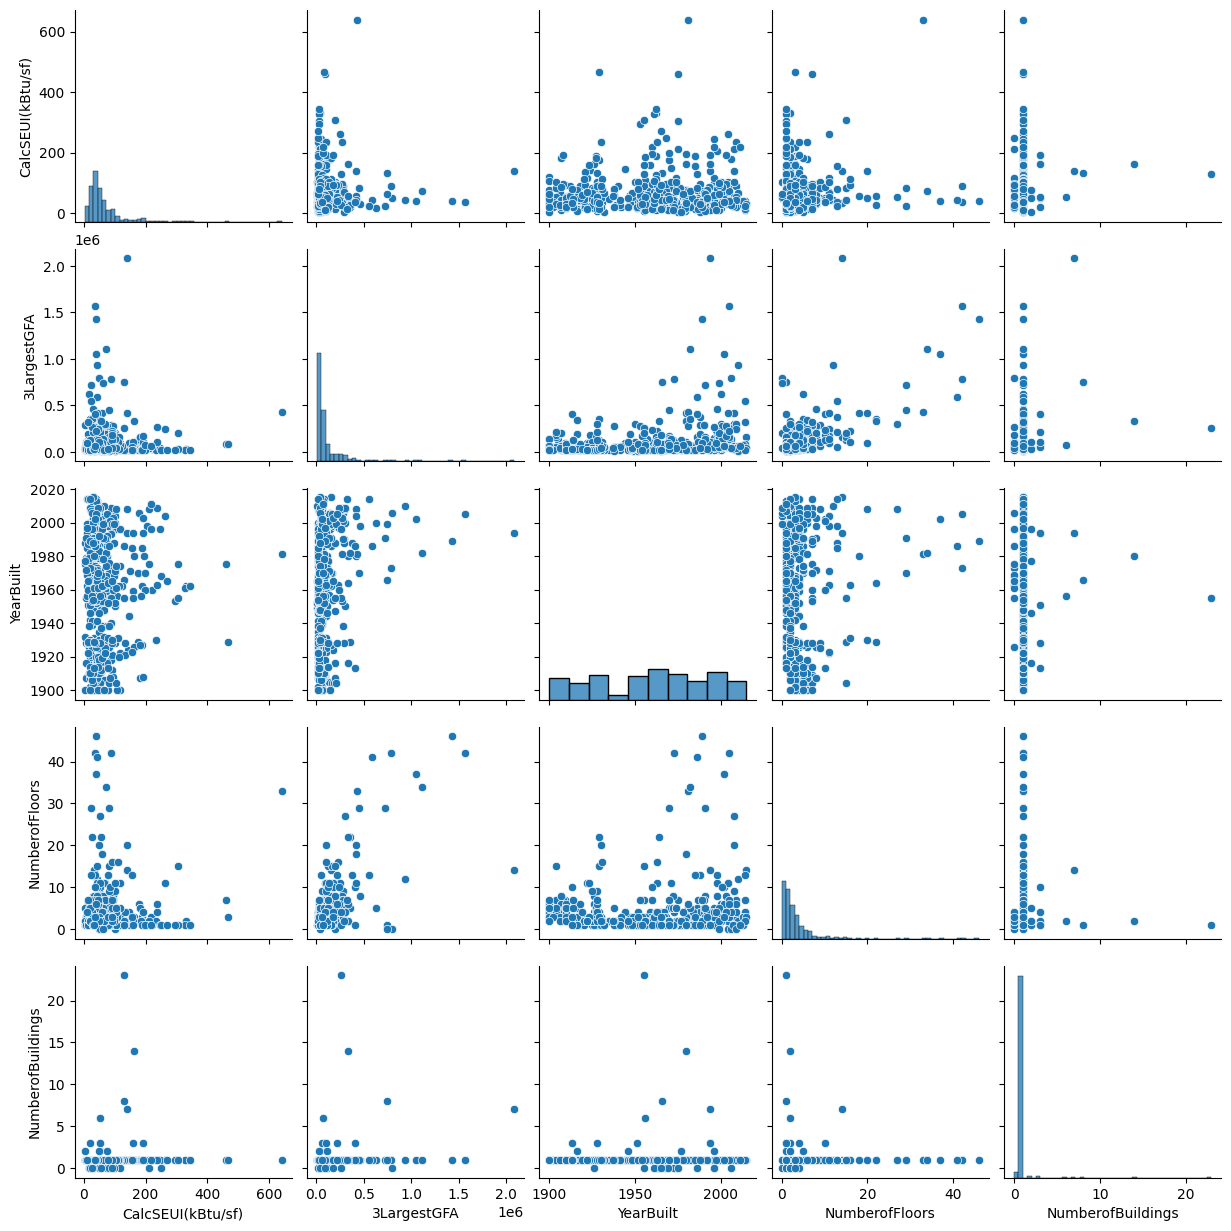

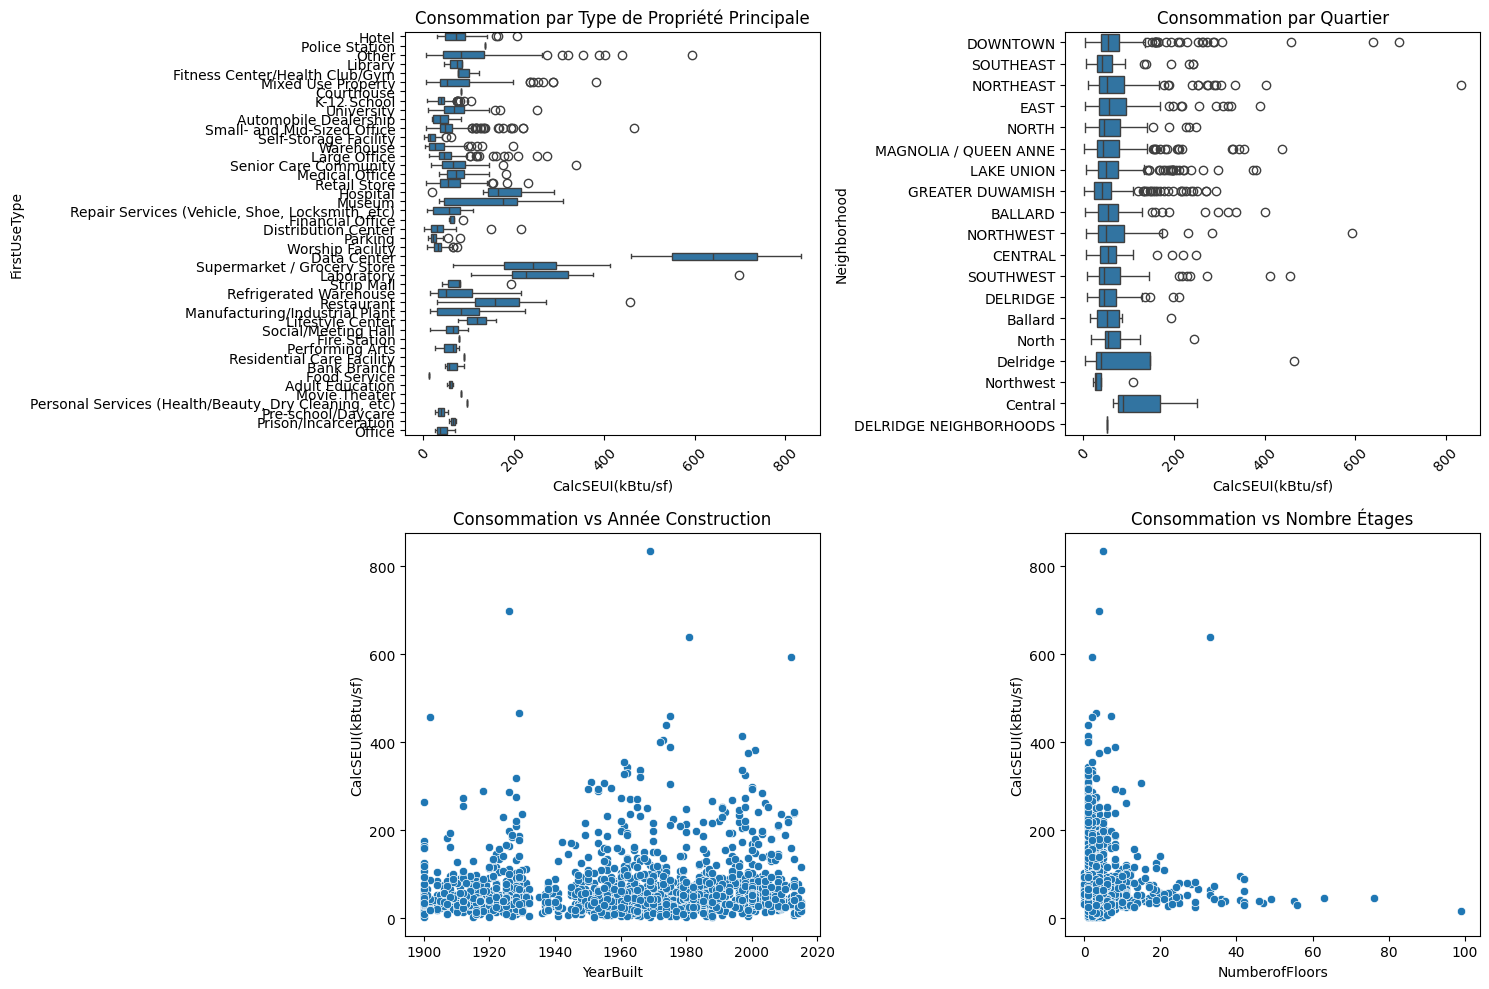

In [447]:
# Choix de 3LargestGFA comme predicteur surface pour l'efficacité
### Analyses supplémentaires EDA
bc_with_target['CalcSEUI(kBtu/sf)'] = bc_with_target['SiteEnergyUse(kBtu)'] / bc_with_target['3LargestGFA']
efficiency_target = 'CalcSEUI(kBtu/sf)'
# 1. Distribution de la target
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(bc_with_target[efficiency_target], bins=50)
plt.title('Distribution de la Target')
plt.yscale('log')  # échelle log car distribution très étalée

plt.subplot(1, 3, 2)
sns.histplot(np.log(bc_with_target[efficiency_target]), bins=50)
plt.title('Distribution de log(Target)')

plt.subplot(1, 3, 3)
sns.boxplot(y=bc_with_target[efficiency_target])
plt.title('Boxplot Target')
plt.tight_layout()
plt.show()

# 2. Pairplot pour variables numériques continues
continuous_vars = [efficiency_target, '3LargestGFA', 'YearBuilt', 
                   'NumberofFloors', 'NumberofBuildings']
sns.pairplot(bc_with_target[continuous_vars].sample(500))  # échantillon pour performance
plt.show()

# 3. Relations target vs features catégorielles importantes
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

# BoxPlots pour relations catégorielles/target
sns.boxplot(data=bc_with_target, y='FirstUseType', 
            x=efficiency_target, ax=axes[0])
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_title('Consommation par Type de Propriété Principale')

sns.boxplot(data=bc_with_target, y='Neighborhood', 
            x=efficiency_target, ax=axes[1])
axes[1].tick_params(axis='x', rotation=45)
axes[1].set_title('Consommation par Quartier')

# Relations numériques/target
sns.scatterplot(data=bc_with_target, x='YearBuilt', 
                y=efficiency_target, ax=axes[2])
axes[2].set_title('Consommation vs Année Construction')

sns.scatterplot(data=bc_with_target, x='NumberofFloors', 
                y=efficiency_target, ax=axes[3])
axes[3].set_title('Consommation vs Nombre Étages')

plt.tight_layout()
plt.show()


#### Traitement des outliers de performances

In [448]:
mask = (bc_with_target['CalcSEUI(kBtu/sf)'] < 5) | (bc_with_target['CalcSEUI(kBtu/sf)']>400)
bc_with_target[mask][['CalcSEUI(kBtu/sf)', 'PrimaryPropertyType', 'FirstUseType', 'YearBuilt','Neighborhood', 'PropertyGFATotal','SecondLargestPropertyUseTypeGFA','3LargestGFA','ComplianceStatus']].sort_values('CalcSEUI(kBtu/sf)')

,CalcSEUI(kBtu/sf),PrimaryPropertyType,FirstUseType,YearBuilt,Neighborhood,PropertyGFATotal,SecondLargestPropertyUseTypeGFA,3LargestGFA,ComplianceStatus
1577,1.430046,Self-Storage Facility,Self-Storage Facility,1915,MAGNOLIA / QUEEN ANNE,39952,NaN,39952.0,Compliant
595,2.115986,Distribution Center,Distribution Center,1969,GREATER DUWAMISH,71718,NaN,71718.0,Compliant
2246,2.304459,Distribution Center,Distribution Center,1952,GREATER DUWAMISH,16300,NaN,65164.0,Compliant
974,3.018623,Warehouse,Warehouse,1900,DOWNTOWN,33300,6000.0,30000.0,Compliant
1576,3.152422,Self-Storage Facility,Self-Storage Facility,1980,MAGNOLIA / QUEEN ANNE,30989,NaN,30989.0,Compliant
380,3.346921,Self-Storage Facility,Self-Storage Facility,1988,MAGNOLIA / QUEEN ANNE,130293,8800.0,139093.0,Compliant
3009,3.459713,Warehouse,Warehouse,1920,EAST,23040,NaN,23040.0,Compliant
609,3.529496,Warehouse,Warehouse,1966,Delridge,170632,5826.0,170632.0,Compliant
378,3.598461,Warehouse,Warehouse,1941,BALLARD,63240,NaN,63240.0,Compliant
1658,3.826589,Self-Storage Facility,Self-Storage Facility,1977,NORTH,33344,984.0,32344.0,Compliant


#### Traitement de l'année de construction

In [449]:
# On regarde le nombre de valeurs manquantes par colonne ainsi que leur type 
phy_cols = ['YearBuilt', 'NumberofFloors', 'NumberofBuildings']
bc_with_target[phy_cols].info()

<class 'pandas.core.frame.DataFrame'>
Index: 1641 entries, 0 to 3375
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   YearBuilt          1641 non-null   int64  
 1   NumberofFloors     1641 non-null   int64  
 2   NumberofBuildings  1641 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 51.3 KB


In [450]:
bc_with_target['YearBuilt'].describe()

count    1641.000000
mean     1962.563681
std        32.506356
min      1900.000000
25%      1931.000000
50%      1966.000000
75%      1989.000000
max      2015.000000
Name: YearBuilt, dtype: float64

In [451]:
mask = (bc_with_target['NumberofBuildings'] < 1) 
bc_with_target[mask][phy_cols]

,YearBuilt,NumberofFloors,NumberofBuildings
63,1965,3,0.0
76,1986,2,0.0
160,1916,4,0.0
201,1968,3,0.0
241,1961,5,0.0
264,1970,1,0.0
278,1926,10,0.0
280,1973,19,0.0
291,1996,4,0.0
358,1955,1,0.0


In [452]:
bc_with_target.loc[mask,'NumberofBuildings']=1
mask = (bc_with_target['NumberofFloors'] < 1) 
bc_with_target[mask][phy_cols]

,YearBuilt,NumberofFloors,NumberofBuildings
166,1999,0,1.0
487,2004,0,1.0
488,2006,0,1.0
564,1999,0,1.0
1754,1945,0,1.0
1993,1991,0,10.0
3130,1940,0,1.0
3131,1960,0,1.0
3132,1960,0,1.0
3168,1929,0,8.0


## Traitement des variables de Géolocalisation :   
    Latitude, Longitude, Neighborhood, CouncilDistrictCode 

In [453]:
geo_col = ['Latitude', 'Longitude', 'Neighborhood', 'CouncilDistrictCode'] 
bc_with_target[geo_col].info()

<class 'pandas.core.frame.DataFrame'>
Index: 1641 entries, 0 to 3375
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Latitude             1641 non-null   float64
 1   Longitude            1641 non-null   float64
 2   Neighborhood         1641 non-null   object 
 3   CouncilDistrictCode  1641 non-null   int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 64.1+ KB


<Axes: ylabel='Longitude'>

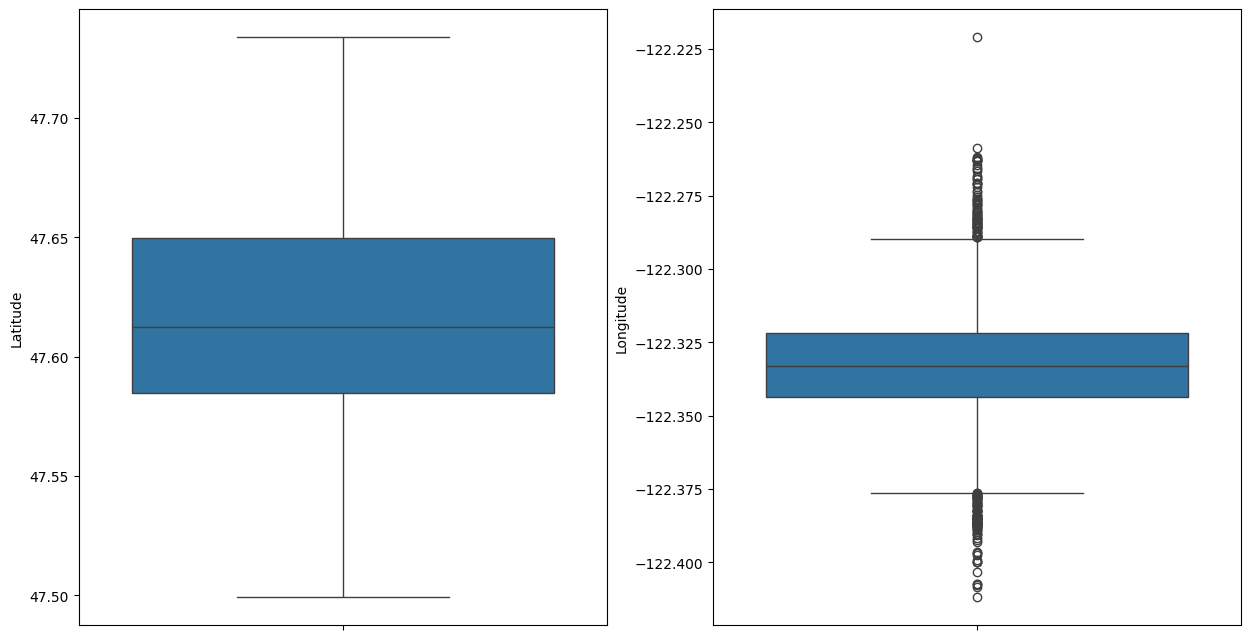

In [454]:
fig,ax = plt.subplots(1,2,figsize=(15,8))
sns.boxplot(bc_with_target['Latitude'], ax=ax[0])
sns.boxplot(bc_with_target['Longitude'], ax=ax[1])


In [455]:
bc_with_target['Neighborhood'] = bc_with_target['Neighborhood'].str.upper()
bc_with_target['Neighborhood'].value_counts()

Neighborhood
DOWNTOWN                  351
GREATER DUWAMISH          342
MAGNOLIA / QUEEN ANNE     150
LAKE UNION                145
EAST                      118
NORTHEAST                 112
NORTHWEST                  90
NORTH                      73
BALLARD                    70
CENTRAL                    54
SOUTHEAST                  47
DELRIDGE                   47
SOUTHWEST                  41
DELRIDGE NEIGHBORHOODS      1
Name: count, dtype: int64

In [456]:
bc_with_target['CouncilDistrictCode'].value_counts()

CouncilDistrictCode
7    519
2    394
3    197
4    155
5    138
1    120
6    118
Name: count, dtype: int64

# Modélisation 

In [457]:
bc_minimal = bc_with_target[['3LargestGFA', 'ListOfAllPropertyUseTypes', 'FirstUseType', 'SecondLargestPropertyUseType', 'YearBuilt', 'NumberofFloors', 'NumberofBuildings','Latitude', 'Longitude', 'Neighborhood',
                                     'SiteEnergyUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)', 'SteamUse(kBtu)']].copy()
bc_minimal

,3LargestGFA,ListOfAllPropertyUseTypes,FirstUseType,SecondLargestPropertyUseType,YearBuilt,NumberofFloors,NumberofBuildings,Latitude,Longitude,Neighborhood,SiteEnergyUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),SteamUse(kBtu)
0,88434.0,Hotel,Hotel,NaN,1927,12,1.0,47.61220,-122.33799,DOWNTOWN,7.226362e+06,3.946027e+06,1.276453e+06,2003882.00
1,103566.0,"Hotel, Parking, Restaurant",Hotel,Parking,1996,11,1.0,47.61317,-122.33393,DOWNTOWN,8.387933e+06,3.242851e+06,5.145082e+06,0.00
2,756493.0,Hotel,Hotel,NaN,1969,41,1.0,47.61393,-122.33810,DOWNTOWN,7.258702e+07,4.952666e+07,1.493800e+06,21566554.00
3,61320.0,Hotel,Hotel,NaN,1926,10,1.0,47.61412,-122.33664,DOWNTOWN,6.794584e+06,2.768924e+06,1.811213e+06,2214446.25
4,191454.0,"Hotel, Parking, Swimming Pool",Hotel,Parking,1980,18,1.0,47.61375,-122.34047,DOWNTOWN,1.417261e+07,5.368607e+06,8.803998e+06,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3371,12294.0,Office,Office,NaN,1990,1,1.0,47.56722,-122.31154,GREATER DUWAMISH,8.497457e+05,5.242709e+05,3.254750e+05,0.00
3372,16000.0,Other - Recreation,Other,NaN,2004,1,1.0,47.59625,-122.32283,DOWNTOWN,9.502762e+05,3.965461e+05,5.537300e+05,0.00
3373,13157.0,"Fitness Center/Health Club/Gym, Other - Recrea...",Other,Fitness Center/Health Club/Gym,1974,1,1.0,47.63644,-122.35784,MAGNOLIA / QUEEN ANNE,5.765898e+06,1.792159e+06,3.973739e+06,0.00
3374,13586.0,"Fitness Center/Health Club/Gym, Food Service, ...",Mixed Use Property,Fitness Center/Health Club/Gym,1989,1,1.0,47.52832,-122.32431,GREATER DUWAMISH,7.194712e+05,3.488702e+05,3.706010e+05,0.00


In [458]:
bc_minimal.corr(numeric_only=True)

,3LargestGFA,YearBuilt,NumberofFloors,NumberofBuildings,Latitude,Longitude,SiteEnergyUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),SteamUse(kBtu)
3LargestGFA,1.000000,0.096476,0.397654,0.730098,0.000640,0.029737,0.857504,0.887180,0.246608,0.503970
YearBuilt,0.096476,1.000000,0.095303,-0.032295,0.064437,0.030564,0.060534,0.070457,0.055828,-0.002266
NumberofFloors,0.397654,0.095303,1.000000,-0.024702,-0.004005,-0.012082,0.221940,0.282672,0.036483,0.100114
NumberofBuildings,0.730098,-0.032295,-0.024702,1.000000,0.019847,0.020316,0.715581,0.761599,0.063051,0.407476
Latitude,0.000640,0.064437,-0.004005,0.019847,1.000000,-0.102461,0.009964,0.011508,0.003409,-0.005591
Longitude,0.029737,0.030564,-0.012082,0.020316,-0.102461,1.000000,0.035568,0.026000,0.037496,0.020926
SiteEnergyUse(kBtu),0.857504,0.060534,0.221940,0.715581,0.009964,0.035568,1.000000,0.956108,0.503866,0.606505
Electricity(kBtu),0.887180,0.070457,0.282672,0.761599,0.011508,0.026000,0.956108,1.000000,0.277658,0.548487
NaturalGas(kBtu),0.246608,0.055828,0.036483,0.063051,0.003409,0.037496,0.503866,0.277658,1.000000,0.021212
SteamUse(kBtu),0.503970,-0.002266,0.100114,0.407476,-0.005591,0.020926,0.606505,0.548487,0.021212,1.000000


## Import des modules 

In [459]:
#Selection
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV, 
    cross_validate,
)
from sklearn.metrics import r2_score, mean_absolute_error , root_mean_squared_error, mean_absolute_percentage_error
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline

#Preprocess
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler,FunctionTransformer

#Modèles
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor


## Feature Engineering

A réaliser : Enrichir le jeu de données actuel avec de nouvelles features issues de celles existantes. 

### Préparation des features pour la modélisation

A réaliser :
* Si ce n'est pas déjà fait, supprimer toutes les colonnes peu pertinentes pour la modélisation.
* Tracer la distribution de la cible pour vous familiariser avec l'ordre de grandeur. En cas d'outliers, mettez en place une démarche pour les supprimer.
* Débarrassez-vous des features redondantes en utilisant une matrice de corrélation.
* Réalisez différents graphiques pour comprendre le lien entre vos features et la target (boxplots, scatterplots, pairplot si votre nombre de features numériques n'est pas très élevé).
*  Séparez votre jeu de données en un Pandas DataFrame X (ensemble de feautures) et Pandas Series y (votre target).
* Si vous avez des features catégorielles, il faut les encoder pour que votre modèle fonctionne.

#### Modes énergétiques

In [460]:
bc_minimal['UseGas'] = (bc_minimal['NaturalGas(kBtu)'].notna()) & (bc_minimal['NaturalGas(kBtu)'] != 0)
bc_minimal['UseSteam'] = (bc_minimal['SteamUse(kBtu)'].notna()) & (bc_minimal['SteamUse(kBtu)'] != 0)
bc_minimal['UseElectricity'] = (bc_minimal['Electricity(kBtu)'].notna()) & (bc_minimal['Electricity(kBtu)'] != 0)


#### Age de la propriété

In [461]:
bc_minimal['AgeProperty']= 2016 - bc_minimal['YearBuilt']
bc_minimal['AgeCategory'] = pd.cut(bc_minimal['AgeProperty'], 
                                  bins=[0, 20, 40, 70, 200], 
                                  labels=['New', 'Recent', 'Old', 'Historic'])


#### Ere de  construction de la propriété

In [462]:
bc_minimal['EnergyEra'] = pd.cut(bc_minimal['YearBuilt'], 
                                bins=[1800, 1980, 2000, 2025], 
                                labels=['Pre-Energy-Crisis', 'Modern', 'Contemporary'])

#### distance du centre ville

In [463]:
seattle_position = (47.6085965,-122.5049456)
bc_minimal['CityDistance'] = np.sqrt(
    (bc_minimal['Latitude'] - seattle_position[0])**2 + 
    (bc_minimal['Longitude'] - seattle_position[1])**2)
bc_minimal['CityDistance'].describe()


count    1641.000000
mean        0.178664
std         0.026149
min         0.099400
25%         0.164800
50%         0.176047
75%         0.192523
max         0.303815
Name: CityDistance, dtype: float64

#### Utilisation multiple

In [464]:
bc_minimal['MultipleUseType'] = bc_minimal['ListOfAllPropertyUseTypes'].str.count('s')+1
bc_minimal['MultipleUseType'].value_counts()

MultipleUseType
1    971
2    537
3     93
4     32
6      3
7      2
5      2
8      1
Name: count, dtype: int64

In [465]:
bc_minimal.columns

Index(['3LargestGFA', 'ListOfAllPropertyUseTypes', 'FirstUseType',
       'SecondLargestPropertyUseType', 'YearBuilt', 'NumberofFloors',
       'NumberofBuildings', 'Latitude', 'Longitude', 'Neighborhood',
       'SiteEnergyUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)',
       'SteamUse(kBtu)', 'UseGas', 'UseSteam', 'UseElectricity', 'AgeProperty',
       'AgeCategory', 'EnergyEra', 'CityDistance', 'MultipleUseType'],
      dtype='object')

## Split train/test

In [466]:
predict_values = ['3LargestGFA', 'MultipleUseType', 'UseSteam', 'UseElectricity', 'UseGas', 'EnergyEra',
       'AgeCategory', 'NumberofFloors', 'NumberofBuildings', 'CityDistance', 'Neighborhood', 'FirstUseType','SecondLargestPropertyUseType']
X = bc_minimal[predict_values]
y = bc_minimal['SiteEnergyUse(kBtu)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Finalisation des features

In [ ]:
# ========================
# ÉTAPE 1: PREPROCESSING PERSONNALISÉ 
# ========================

def fix_floors_and_discretize(df):
    """Fonction qui fait tout votre preprocessing d'un coup"""
    df = df.copy()
    
    # 1. Corriger NumberofFloors
    mask = (df['NumberofFloors'] < 1)
    OneBuildingMeanFloor = df[df['NumberofBuildings']==1]["NumberofFloors"].mean()
    OneBuildingMeanFloor = int(OneBuildingMeanFloor.round(0))
    df.loc[mask,'NumberofFloors'] = OneBuildingMeanFloor
    
    # 2. Créer AvgFloor (comme vous faisiez)
    df['AvgFloor'] = df['NumberofFloors']/df['NumberofBuildings']
    
    
    # 5. PropertySize (3LargestGFA) – quantiles auto sur train
    if not hasattr(fix_floors_and_discretize, 'size_bins'):
        _, fix_floors_and_discretize.size_bins = pd.qcut(
            df['3LargestGFA'], q=4, retbins=True, duplicates='drop'
        )
    df['PropertySize'] = pd.cut(df['3LargestGFA'],
                                bins=fix_floors_and_discretize.size_bins,
                                labels=['Small', 'Mid', 'Large', 'XLarge'],
                                include_lowest=True)
    
    # 6. HeightCategory (NumberofFloors) – quantiles auto sur train
    if not hasattr(fix_floors_and_discretize, 'floor_bins'):
        _, fix_floors_and_discretize.floor_bins = pd.qcut(
            df['NumberofFloors'], q=3, retbins=True, duplicates='drop'
        )
    df['HeightCategory'] = pd.cut(df['NumberofFloors'],
                                  bins=fix_floors_and_discretize.floor_bins,
                                  labels=['Low', 'Mid', 'High'],
                                  include_lowest=True)
    return df

# ========================
# ÉTAPE 2: PIPELINE COMPLET
# ========================

# Colonnes après votre preprocessing
categorical_features = ['FirstUseType', 'PropertySize',
                       'Neighborhood','AgeCategory','EnergyEra','HeightCategory']  # Ajoutez vos autres catégories ici

numerical_features = ['3LargestGFA',  
                     'CityDistance', 'MultipleUseType', 'NumberofFloors','NumberofBuildings']

# Pipeline complet
full_pipeline = Pipeline([
    # Étape 1: Preprocessing personnalisé
    ('preprocessing', FunctionTransformer(fix_floors_and_discretize, validate=False)),
    
    # Étape 2: Encodage + Normalisation
    ('encoder', ColumnTransformer([
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), 
         categorical_features),
        ('num', StandardScaler(), numerical_features)
    ], remainder='passthrough'))
])

# ========================
# ÉTAPE 3: APPLICATION 
# ========================

# Fit sur train et transform train/test
X_train_transformed = full_pipeline.fit_transform(X_train)
X_test_transformed = full_pipeline.transform(X_test)

# ========================
# ÉTAPE 4: CRÉER VOS DataFrames _final
# ========================

# Récupérer les noms des colonnes
onehot = full_pipeline.named_steps['encoder'].named_transformers_['cat']
onehot_names = onehot.get_feature_names_out(categorical_features)
num_names = [f"scaled_{col}" for col in numerical_features]

# Colonnes restantes (passthrough)
all_cols_after_preprocessing = fix_floors_and_discretize(X_train).columns
remaining_cols = [col for col in all_cols_after_preprocessing 
                 if col not in categorical_features + numerical_features]

# Noms finaux
final_feature_names = list(onehot_names) + num_names + remaining_cols

# Vos DataFrames finaux
X_train_final = pd.DataFrame(X_train_transformed, columns=final_feature_names)
X_test_final = pd.DataFrame(X_test_transformed, columns=final_feature_names)

# Conversion en numérique
for col in X_train_final.columns:
    X_train_final[col] = pd.to_numeric(X_train_final[col], errors='coerce')
    X_test_final[col] = pd.to_numeric(X_test_final[col], errors='coerce')

#X_train_final.drop(columns=['NumberofFloors', 'NumberofBuildings'], inplace=True)
#X_test_final.drop(columns=['NumberofFloors', 'NumberofBuildings'], inplace=True)

print(f"✅ Pipeline terminé!")
print(f"Shape finale: Train {X_train_final.shape}, Test {X_test_final.shape}")


✅ Pipeline terminé!
Shape finale: Train (1312, 118), Test (329, 118)


## Normalisation

In [469]:
X_train_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1312 entries, 0 to 1311
Columns: 118 entries, FirstUseType_Automobile Dealership to AvgFloor
dtypes: bool(3), float64(115)
memory usage: 1.2 MB


### Vérification et normalisation

A réaliser :
* Pour chaque algorithme que vous allez tester, vous devez :
    * Réaliser au préalable une séparation en jeu d'apprentissage et jeu de test via une validation croisée.
    * Si les features quantitatives que vous souhaitez utiliser ont des ordres de grandeur très différents les uns des autres, et que vous utilisez un algorithme de regression qui est sensible à cette différence, alors il faut réaliser un scaling (normalisation) de la donnée au préalable.
    * Entrainer le modèle sur le jeu de Train
    * Prédire la cible sur la donnée de test (nous appelons cette étape, l'inférence).
    * Calculer les métriques de performance R2, MAE et RMSE sur le jeu de train et de test.
    * Interpréter les résultats pour juger de la fiabilité de l'algorithme.
* Vous pouvez choisir par exemple de tester un modèle linéaire, un modèle à base d'arbres et un modèle de type SVM
* Déterminer le modèle le plus performant parmi ceux testés.

In [470]:
# CODE COMPARAISON DES MODELES

models = {
    'DummyRegressor': DummyRegressor(strategy='mean'),
    'LinearRegression': LinearRegression(),
    'SVR': SVR(),
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'RandomForest': RandomForestRegressor(random_state=42, n_jobs=-1)
}

cv_results = {}
scoring = ['neg_root_mean_squared_error', 'r2', 'neg_mean_absolute_error']

print("=== COMPARAISON MODÈLES avec Cross-Validation ===")
for name, model in models.items():
    print(f"\n{name}:")
    
    # Cross-validation 5-fold
    scores = cross_validate(model, X_train_final, y_train, 
                          cv=5, scoring=scoring, n_jobs=-1)
    
    cv_results[name] = {
        'RMSE_mean': -scores['test_neg_root_mean_squared_error'].mean(),
        'RMSE_std': scores['test_neg_root_mean_squared_error'].std(),
        'R2_mean': scores['test_r2'].mean(),
        'R2_std': scores['test_r2'].std(),
        'MAE_mean': -scores['test_neg_mean_absolute_error'].mean(),
        'MAE_std': scores['test_neg_mean_absolute_error'].std(),
    }
    
    print(f"  RMSE: {cv_results[name]['RMSE_mean']:.0f} (±{cv_results[name]['RMSE_std']:.0f})")
    print(f"  R² mean: {cv_results[name]['R2_mean']:.4f} (±{cv_results[name]['R2_std']:.4f})")
    print(f"  R² std: {cv_results[name]['R2_std']:.4f} (±{cv_results[name]['R2_mean']:.4f})")
    print(f"  MAE: {cv_results[name]['MAE_mean']:.0f} (±{cv_results[name]['MAE_std']:.0f})")

# Identifier le meilleur modèle basé sur R² moyen
best_model_name = max(cv_results.keys(), key=lambda x: cv_results[x]['R2_mean'])
print(f"\n🏆 Meilleur modèle selon CV: {best_model_name}")

=== COMPARAISON MODÈLES avec Cross-Validation ===

DummyRegressor:


/usr/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib/pyth

  RMSE: 29013479 (±15283768)
  R² mean: -0.0166 (±0.0297)
  R² std: 0.0297 (±-0.0166)
  MAE: 9978119 (±1390300)

LinearRegression:


/usr/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)


  RMSE: 16760918 (±3946167)
  R² mean: 0.4029 (±0.4220)
  R² std: 0.4220 (±0.4029)
  MAE: 6108227 (±748310)

SVR:
  RMSE: 29634016 (±15354779)
  R² mean: -0.0668 (±0.0338)
  R² std: 0.0338 (±-0.0668)
  MAE: 7630379 (±1727349)

GradientBoosting:
  RMSE: 28697276 (±13700162)
  R² mean: -0.3994 (±1.2972)
  R² std: 1.2972 (±-0.3994)
  MAE: 5740090 (±1719115)

RandomForest:
  RMSE: 24416143 (±10121306)
  R² mean: 0.1712 (±0.2453)
  R² std: 0.2453 (±0.1712)
  MAE: 5099035 (±879454)

🏆 Meilleur modèle selon CV: LinearRegression


### Optimisation et interprétation du modèle

A réaliser :
* Reprennez le meilleur algorithme que vous avez sécurisé via l'étape précédente, et réalisez une GridSearch de petite taille sur au moins 3 hyperparamètres.
* Si le meilleur modèle fait partie de la famille des modèles à arbres (RandomForest, GradientBoosting) alors utilisez la fonctionnalité feature importance pour identifier les features les plus impactantes sur la performance du modèle. Sinon, utilisez la méthode Permutation Importance de sklearn. 

In [381]:
# CODE OPTIMISATION ET INTERPRETATION DU MODELE
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
# Définir une petite grille d’hyperparamètres à tester
param_grid = {
    'n_estimators': [100, 200],          # nombre d’arbres
    'max_depth': [10, 20, None],         # profondeur max des arbres
    'min_samples_split': [2, 5]          # nombre min d’échantillons pour split
}

# Créer et configurer la GridSearch
gs = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',  # RMSE négatif car maximisation par GridSearch
    cv=3,                                  # validation croisée 3 folds pour rapidité
    n_jobs=-1,
    verbose=1
)

# Exécuter la recherche sur le train
gs.fit(X_train_final, y_train)

# Afficher les meilleurs paramètres et score
print("Best parameters:", gs.best_params_)
print("Best RMSE (neg):", gs.best_score_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Best RMSE (neg): -22648029.868188944


### Résultat V1 'main'


Recalculated RMSE: 8594300.258724326  
Recalculated R2: 0.7820465641162211  
Recalculated MAE: 3339004.45232972  
Recalculated MAPE: 0.8307252249062986  



In [382]:
best_model = gs.best_estimator_

importances = best_model.feature_importances_
feature_names = X_train_final.columns

# Affichage du top 15 features les plus importantes
sorted_idx = importances.argsort()[::-1]
print("Top 10 features by importance:")
for idx in sorted_idx[:30]:
    print(f"- {feature_names[idx]}: {importances[idx]:.4f}")

Top 10 features by importance:
- scaled_3LargestGFA: 0.4487
- scaled_AvgFloor: 0.3424
- FirstUseType_Hospital: 0.0589
- scaled_CityDistance: 0.0325
- SecondLargestPropertyUseType_Laboratory: 0.0209
- SecondLargestPropertyUseType_Office: 0.0112
- SecondLargestPropertyUseType_nan: 0.0081
- FirstUseType_Mixed Use Property: 0.0081
- HeightCategory_Mid: 0.0065
- SecondLargestPropertyUseType_Parking: 0.0049
- FirstUseType_Other: 0.0044
- FirstUseType_University: 0.0042
- scaled_MultipleUseType: 0.0041
- Neighborhood_EAST: 0.0039
- Neighborhood_NORTHEAST: 0.0035
- UseGas: 0.0030
- EnergyEra_Modern: 0.0028
- FirstUseType_Laboratory: 0.0028
- UseSteam: 0.0025
- EnergyEra_Pre-Energy-Crisis: 0.0024
- AgeCategory_Old: 0.0022
- SecondLargestPropertyUseType_Data Center: 0.0021
- Neighborhood_GREATER DUWAMISH: 0.0020
- AgeCategory_Recent: 0.0019
- FirstUseType_Hotel: 0.0016
- FirstUseType_Supermarket / Grocery Store: 0.0014
- HeightCategory_Low: 0.0013
- Neighborhood_LAKE UNION: 0.0012
- FirstUseType

In [383]:
y_pred = best_model.predict(X_test_final)
rmse = root_mean_squared_error(y_test, y_pred)  
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"Recalculated RMSE: {rmse}")
print(f"Recalculated R2: {r2}")
print(f"Recalculated MAE: {mae}")
print(f"Recalculated MAPE: {mape}")

Recalculated RMSE: 10063084.65789107
Recalculated R2: 0.7011832573443102
Recalculated MAE: 3580844.5465306523
Recalculated MAPE: 0.8513488591718901
